# ASR Test Simulation: Phreeqc Example 11 Chemistry

NOTE: This [Jupytext](https://jupytext.readthedocs.io/en/latest/index.html) paired notebook, with paired `.py` and `.ipynb` files. 
- If using VS Code, install the the [Jupytext Sync extension](https://jupytext.readthedocs.io/en/latest/vs-code.html) for maximum benefit.


The workflow for this example:
- Read geochemical components and their initial and boundary concentrations from PHREEQC input files
- Create new Modflow 6 transport model for each aqueous phase (components in the Solution blocks) and add their initial concentrations over the entire DISV grid.
- Modify the Modflow 6 Flow Well package Stress Period Data (SPD) by adding Solution component concentrations.
- Run the modified Modflow 6 for conservative transport of all components (i.e. no coupling to PHREEQC)
- Run the coupled Modflow 6 & PHREEQC models for the entire simulation



## Simple ASR Test Case

Grid type: DISV  
Grid Size: ~4800 ft x 4700 ft  
Grid cells 1.2 ft – 155 ft  
Cells per layer = 1032  
Total cells = 5160  

Grid Layers:
 - Layer 1: heads of all cells specified with CHD
 - Layer 2: side boundaries set with GHB
 - Layer 3: side boundaries set with GHB
 - Layer 4: side boundaries set with GHB
 - Layer 5: heads of all cells specified with CHD

ASR Well simulated using WEL package
 - 21 Stress Periods

New stress period when ASR pumping changes and at the start of each month
 - ~ 10-day time steps
 - Simulation run time ~25-30 seconds

Simplifying assumptions:
 - ASR Well injected or extracted at a constant rate of 5 MGD
 - TDS and temperature of injected water was constant at 150 mg/L and 25C
 - GHBs were setup using map coverages in GMS.  Heads were pulled from the old KRASR SEAWAT local scale model at a few points along the test model boundary, then the map module was used to interpolate the heads to the boundary cells.  The head contours along the boundaries look a little strange during injection and recovery, but it should be ok for the purposes of the test model
 - TDS and temperature were assumed to be constant along the model boundaries but varied by model layer based on the KRASR local scale model results
 - Specific storage was constant for each layer

# Installation and Setup

Create a custom conda virtual environment can be created using the `environment.yml` file included in this repo.

## Python Imports

In [1]:
import os
import shutil
from pathlib import Path
from importlib import reload

import numpy as np
from numpy.lib import recfunctions as rfn
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

import flopy
from modflowapi import ModflowApi
import phreeqcrm

<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute


In [2]:
# Import the MFRTM package, installed using `conda develop`
import mf6rtm

display(mf6rtm.__file__)
try:
    # if current LimnoTech development version
    display(mf6rtm.__version__)
except AttributeError:
    pass

'/Users/aaufdenkampe/Documents/git_mf6rtm/mf6rtm/mf6rtm/__init__.py'

'0.1.11+externalio.dev'

In [3]:
import utils # from this repo

NOTE: the notebook below runs from the `externalio` branch the upstream repo 
(Pablo's) https://github.com/p-ortega/mf6rtm/tree/feature/externalio

### If you get `ModuleNotFoundError`

Run the `01-GettingStarted.ipynb` notebook to install `mf6rtm` using `conda develop`.

## Set Paths to Input and Output Files with `pathlib`

Use the [pathlib](https://docs.python.org/3/library/pathlib.html) library 
(built-in to Python 3) to manage paths indpendentely of OS or environment. 
See this [blog post]
(https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f) 
to learn about the many benefits over using the `os` library.

In [4]:
# Find your current working directory, which should be folder for this notebook.
working_dir = Path.cwd()
# Find repository path (i.e. the parent to `/examples` directory for this notebook)
repo_path = working_dir.parent.parent
repo_path

PosixPath('/Users/aaufdenkampe/Documents/git_mf6rtm/mf6rtm-asr-example')

In [5]:
simulation_name = working_dir.name
simulation_name

'sim01-ex11'

In [6]:
# Path to simulation workspace, which is git-ignored and 
# will get over-written with each run of this notebook
sim_ws = working_dir / 'ws'
sim_ws.mkdir(parents=True, exist_ok=True)

In [7]:
# Delete previous contents from simulation
if sim_ws.exists():
    try:
        shutil.rmtree(sim_ws)
        print(f"Directory '{sim_ws}' and its contents removed successfully.")
        sim_ws.mkdir(parents=True, exist_ok=True)
    except OSError as e:
        print(f"Error: {sim_ws} : {e.strerror}")
else:
    print(f"Directory '{sim_ws}' does not exist.")

Directory '/Users/aaufdenkampe/Documents/git_mf6rtm/mf6rtm-asr-example/sims/sim01-ex11/ws' and its contents removed successfully.


### Modflow Inputs

In [8]:
# Modflow inputs file folder
mf6_inputs_path = repo_path / 'data' / 'MF6_ASR_DISV_inputs'
mf6_input_files = os.listdir(mf6_inputs_path)

In [9]:
# Copy input files to simulation workspace directory)
for file in mf6_input_files:
    shutil.copy2(mf6_inputs_path / file, sim_ws)

In [10]:
# Add required empty output folders
folders = [
    'flow_output',
    'trans-TDS_output',
    'trans-temp_output',
]
for folder in folders:
    path = sim_ws / folder
    path.mkdir(parents=True, exist_ok=True)

In [11]:
# Set filepath for the MF6 simulation configuration file
sim_nam_file_path = sim_ws / "mfsim.nam"
assert sim_nam_file_path.exists(), "MF6 sim file exists!"
sim_nam_file_path

PosixPath('/Users/aaufdenkampe/Documents/git_mf6rtm/mf6rtm-asr-example/sims/sim01-ex11/ws/mfsim.nam')

In [12]:
# Set modflow input path equal to simulation workspace
mf6_input_path = sim_ws

### PHREEQC Inputs

In [13]:
# Phreeqc input file folder
chem_inputs_path = working_dir / "chem_inputs"
chem_input_files = os.listdir(chem_inputs_path)
chem_input_files

['chem_exchanges.csv',
 'chem_postfix.phqr',
 'chem_ex11.pqi',
 'chem_solutions.csv']

In [14]:
# Copy input files to simulation workspace directory (i.e. project path)
for file in chem_input_files:
    shutil.copy2(chem_inputs_path / file, sim_ws)

In [15]:
# Path to PHREEQC Block Input CSV Files
solutions_filepath = sim_ws / "chem_solutions.csv"
exchanges_filepath = sim_ws / "chem_exchanges.csv"
print("PHREEQC input files exist?", solutions_filepath.exists(), exchanges_filepath.exists(), )

PHREEQC input files exist? True True


In [16]:
# Path to file with PHREEQC Input "postfix" instructions
# to be appended to the PHREEQC Input file (*.pqi) created by mf6rtm
postfix_filepath = sim_ws /  'chem_postfix.phqr'
postfix_filepath.exists()

True

In [17]:
# Select PHREEQC database file
phreeqc_database_file = "phreeqc.dat"
phreeqc_databases_path = repo_path / "data" / "chem_databases"
phreeqc_database_filepath = phreeqc_databases_path / phreeqc_database_file
print("PHREEQC database file exists?", phreeqc_database_filepath.exists())

PHREEQC database file exists? True


In [18]:
# Paths to PHREEQC configuration files that will be created by mf6trm
# PHREEQC Input file (*.pqi)
phreeqc_input_filepath = sim_ws / "phinp.dat"
# PhreeqcRM YAML config file
phreeqcrm_yaml_filepath = sim_ws / "mf6rtm.yaml"
print("MF6RTM-created PHREEQCRM YAML file exists?", phreeqcrm_yaml_filepath.exists())

MF6RTM-created PHREEQCRM YAML file exists? False


## Set Path to MF6 Executable & Library
Different versions can be downloaded from: https://github.com/MODFLOW-ORG/executables to a folder similar to this: `bin/mf6.5.0/macarm` 

On Mac, will need to give permissions with these terminal commands from the 
```sh
xattr -dr com.apple.quarantine mf6
xattr -dr com.apple.quarantine libmf6.dylib
```


In [19]:
use_version_installed_with_modflowapi = False
# user = "Laren"
user = "Anthony"
# version = "6.4.2"
version = "6.5.0"
os = "macarm"

try:
    mf6_exe = "mf6"
    dll = "libmf6"
    mf6_version = !{mf6_exe} --version
    mf6dll_version = ModflowApi("libmf6").get_version()
    print(f"Executable & library installed with modflowapi: {mf6_version[1]}, dll: {mf6dll_version}")
except Exception:
    print("Modflow executables not found in environment")

if use_version_installed_with_modflowapi:
    print(f"Using executable installed with modflowapi: {mf6_version[1]}")
else:
    if user == "Lauren":
        # If using executable from GMS
        mf6_bin_path = Path(r"C:/program files/gms 10.8 64-bit/python/lib/site-packages/xms/executables/modflow6")
        mf6_exe = mf6_bin_path / "mf6.exe"
        dll = mf6_bin_path / "libmf6.dll"
    elif user == "Anthony":
        mf6_bin_path = repo_path / "bin" / f"mf{version}" / os
        mf6_exe = mf6_bin_path / "mf6"
        dll = mf6_bin_path / "libmf6.dylib"
    else:
        print("Create a new user and set paths to mf6 and libmf6")

mf6_version = !{mf6_exe} --version
mf6dll_version = ModflowApi(dll).get_version()
print(f"User-selected executable ({mf6_exe.exists()}): {mf6_version[1]}, dll: {mf6dll_version}")

Executable & library installed with modflowapi: mf6: 6.6.3 09/29/2025, dll: 6.6.3
User-selected executable (True): mf6: 6.5.0 05/23/2024, dll: 6.5.0


In [20]:
# Copy executable and library to simulation workspace
shutil.copy2(mf6_exe, sim_ws)
shutil.copy2(dll, sim_ws)
(sim_ws/mf6_exe.name).exists()

True

## Utility Functions

These functions are available in `src/utils.py`:
- `run_models()`
- `write_models()`
- `create_mf6_gwt()`
- `get_times_c()`
- `get_concentrations()`
- `convert_molL_gL()`
- `convert_molL_kgft3()`
- `modify_wel_spd()`

# Load Modflow 6 Simulation for Reactive Transport
To set up PhreeqcRM and MF6RTM simulation objects.
Modifies Modflow 6 input files to include transport models for all reactive transport species.

In [21]:
# Load simulation using Flopy
sim = flopy.mf6.MFSimulation.load(
    sim_ws=sim_ws,
    exe_name=mf6_exe,  #'mf6',
    verbosity_level=0,
)
sim.model_names

['flow', 'trans-tds', 'trans-temp']

## Modify Flow Model

In [22]:
# load existing gwf model
for model_name in sim.model_names:
    model = sim.get_model(model_name)
    if model.model_type == "gwf6":
        gwf = model
        print(gwf.name)
gwf.get_package_list()

flow


['DISV', 'NPF', 'IC', 'OC', 'WEL', 'STO', 'CHD', 'GHB', 'BUY']

In [23]:
# removes buy package from gwf model
gwf.remove_package("buy")
gwf.get_package_list()

['DISV', 'NPF', 'IC', 'OC', 'WEL', 'STO', 'CHD', 'GHB']

In [24]:
# modify output control package to not print head to .lst file
oc = gwf.get_package("oc")
print_record = oc.printrecord.get_data()
print_rec = print_record[0]
mask = ~(
    (print_rec.rtype == "head")
    & (print_rec.ocsetting == "all")
    & (print_rec.ocsetting_data == None)
)
print_record_new = {}
print_record_new[0] = print_record[0][mask]
oc.printrecord.set_data(print_record_new)

In [25]:
# modify npf package to save specific discharge
npf = gwf.get_package("npf")
npf.save_specific_discharge = True

## Read Grid Info

In [26]:
# Get groundwater model names and grid info
for model_name in sim.model_names:
    # Collect model info 
    model = sim.get_model(model_name)
    model_type = model.model_type
    grid_type = model.get_grid_type()
    grid_units = model.modelgrid.units
    # Collect grid information
    grid_package = model.get_package(grid_type.name)
    nlay = grid_package.nlay.get_data()  # number of layers
    ncpl = grid_package.ncpl.get_data()  # number of cells per layer
    print(f"{model_name}: ", model_type, grid_type.name, grid_units, nlay, ncpl)

flow:  gwf6 DISV feet 5 1032
trans-tds:  gwt6 DISV feet 5 1032
trans-temp:  gwt6 DISV feet 5 1032


In [27]:
# Use spatial discretization info from the last model
# Calculate total number of grid cells
nxyz = nlay * ncpl
nxyz

5160

In [28]:
# Get groundwater flow model object
# defined above
display(gwf.name, gwf.get_package_list())

'flow'

['DISV', 'NPF', 'IC', 'OC', 'WEL', 'STO', 'CHD', 'GHB']

### Cell Spacing

In [29]:
grid_package.length_units

{internal}
('feet')

In [30]:
celldata = grid_package.cell2d.get_data()
# data stored in numpy record arrays  
# can be easily converted to pandas dataframes
cells_df = pd.DataFrame.from_records(celldata, index='icell2d')
cells_df

,xc,yc,ncvert,icvert_0,icvert_1,icvert_2,icvert_3,icvert_4,icvert_5
icell2d,,,,,,,,,
0,694376.128,1027688.90,4,3,2,1,0,None,None
1,694530.765,1027688.90,4,5,4,2,3,None,None
2,694685.402,1027688.90,4,7,6,4,5,None,None
3,694840.039,1027688.90,4,9,8,6,7,None,None
4,694994.676,1027688.90,4,11,10,8,9,None,None
...,...,...,...,...,...,...,...,...,...
1027,698396.693,1023169.38,4,1092,1124,1123,1091,None,None
1028,698551.330,1023169.38,4,1093,1125,1124,1092,None,None
1029,698705.967,1023169.38,4,1094,1126,1125,1093,None,None


In [31]:
verticedata = grid_package.vertices.get_data()
vertices_df = pd.DataFrame.from_records(verticedata, index='iv')
vertices_df

,xv,yv
iv,,
0,694298.809,1027766.82
1,694298.809,1027610.97
2,694453.446,1027610.97
3,694453.446,1027766.82
4,694608.083,1027610.97
...,...,...
1124,698474.011,1023091.45
1125,698628.649,1023091.45
1126,698783.286,1023091.45


In [32]:
domain_size = vertices_df.max() - vertices_df.min()
domain_size

xv    4793.751
yv    4675.370
dtype: float64

## Read Time Step Info

In [33]:
# Get time discretization info from the `tdis` package
tdis = sim.tdis
nper = tdis.nper.get_data()          # number of stress periods
perioddata = tdis.perioddata.get_data()
nstp = perioddata['nstp']            # number of timesteps per stress period
perlen = perioddata['perlen']        # length of stress periods
tsmult = perioddata['tsmult']        # timestep multiplier
t_units = tdis.time_units.get_data() # units

print(f'{nper} stress periods. Units: {t_units}')
print(nstp)
print(perlen)
print(tsmult)

21 stress periods. Units: days
[1 2 3 3 3 3 3 1 2 3 3 3 3 3 1 3 3 3 3 3 2]
[ 1. 13. 28. 31. 30. 31. 30.  9. 22. 31. 30. 31. 30. 31.  3. 28. 28. 31.
 30. 31. 16.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Read Stress Period Info

In [34]:
# boundary conditions for chem_stress
# get boundary condition packages with transport
# read in spd stress period data ... which varries based on package...

# for well package (wel):
wel = gwf.get_package('wel')
if wel.has_stress_period_data == True:
    spd_wel_dict = wel.stress_period_data.get_data(full_data=True) # full data is default
display(spd_wel_dict)

{0: rec.array([((2, 495), 0, 0.00429, 25, 1, 'krasr')],
           dtype=[('cellid', 'O'), ('q', '<i8'), ('tds', '<f8'), ('temp', '<i8'), ('cellgrp', '<i8'), ('boundname', 'O')]),
 1: rec.array([((2, 495), 668359.845, 0.00429, 25, 1, 'krasr')],
           dtype=[('cellid', 'O'), ('q', '<f8'), ('tds', '<f8'), ('temp', '<i8'), ('cellgrp', '<i8'), ('boundname', 'O')]),
 2: rec.array([((2, 495), 668359.845, 0.00429, 25, 1, 'krasr')],
           dtype=[('cellid', 'O'), ('q', '<f8'), ('tds', '<f8'), ('temp', '<i8'), ('cellgrp', '<i8'), ('boundname', 'O')]),
 3: rec.array([((2, 495), 668359.845, 0.00429, 25, 1, 'krasr')],
           dtype=[('cellid', 'O'), ('q', '<f8'), ('tds', '<f8'), ('temp', '<i8'), ('cellgrp', '<i8'), ('boundname', 'O')]),
 4: rec.array([((2, 495), 668359.845, 0.00429, 25, 1, 'krasr')],
           dtype=[('cellid', 'O'), ('q', '<f8'), ('tds', '<f8'), ('temp', '<i8'), ('cellgrp', '<i8'), ('boundname', 'O')]),
 5: rec.array([((2, 495), 668359.845, 0.00429, 25, 1, 'krasr')],

In [35]:
# modify well q to try and address convergence issues
for sp in range(len(spd_wel_dict)):
    spd_wel_dict[sp]['q'] = spd_wel_dict[sp]['q'] / 2.

# reset wel stress period data using modified q
wel.stress_period_data = spd_wel_dict
spd_wel_dict_edit = wel.stress_period_data.get_data(full_data=True)

In [36]:
# data stored in a dictionary of numpy record arrays, 
# each of which can be easily converted to a pandas dataframe
stress_period_id = 3
pd.DataFrame.from_records(spd_wel_dict[stress_period_id])

,cellid,q,tds,temp,cellgrp,boundname
0,"(2, 495)",334179.9225,0.00429,25,1,krasr


In [37]:
# flopy has a convenient dataframe interface 
# that also includes, the auxilary data (i.e. components) when present
spd_wel_df_dict = wel.stress_period_data.dataframe
spd_wel_df_dict[stress_period_id]

,cellid_layer,cellid_cell,q,tds,temp,cellgrp,boundname
0,2,495,334179.9225,0.00429,25,1,krasr


In [38]:
# ... which allows easy concatination into a single dataframe
spd_wel_df = pd.concat(spd_wel_df_dict.values(), keys=spd_wel_df_dict.keys())
spd_wel_df = spd_wel_df.droplevel(level=1)
# spd_wel_df.index.set_names(['stress_period_id'], inplace=True)
spd_wel_df.info()
spd_wel_df

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 0 to 20
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cellid_layer  21 non-null     int64  
 1   cellid_cell   21 non-null     int64  
 2   q             21 non-null     float64
 3   tds           21 non-null     float64
 4   temp          21 non-null     int64  
 5   cellgrp       21 non-null     int64  
 6   boundname     21 non-null     object 
dtypes: float64(2), int64(4), object(1)
memory usage: 1.3+ KB


,cellid_layer,cellid_cell,q,tds,temp,cellgrp,boundname
0,2,495,0.0000,0.00429,25,1,krasr
1,2,495,334179.9225,0.00429,25,1,krasr
2,2,495,334179.9225,0.00429,25,1,krasr
3,2,495,334179.9225,0.00429,25,1,krasr
4,2,495,334179.9225,0.00429,25,1,krasr
5,2,495,334179.9225,0.00429,25,1,krasr
6,2,495,334179.9225,0.00429,25,1,krasr
7,2,495,334179.7075,0.00429,25,1,krasr
8,2,495,0.0000,0.00429,25,1,krasr
9,2,495,0.0000,0.00429,25,1,krasr


NOTE: `cellid` is the cell identifier, and depends on the type of grid that is used for the simulation. 
- For a structured grid that uses the DIS input file, CELLID is the layer, row, and column. 
- For a grid that uses the DISV input file, CELLID is the layer and CELL2D number. 
- If the model uses the unstructured discretization (DISU) input file, CELLID is the node number for the cell.

# Get Geochemistry for Transport Models and their Initial Conditions

This first step is to create MF6 Groundwater Transport Models (GWT) for each transportable geochemical component, including setting initial conditions (IC).

This requires running an initial PHREEQC calculation from measured inputs, using utilities from the [`mf6rtm`](https://github.com/p-ortega/mf6rtm) package. 

Our workflow, similar to [`mf6rtm` example 4](https://github.com/p-ortega/mf6rtm/blob/main/benchmark/ex4.ipynb), requires these steps:
- read inputs by PHREEQC "keyword data blocks"
- convert to a dictionary
- instantiate `mup3d.{Block}` classes that contain the block's geochemical components
- set the grid size/shape for the components

### SOLUTION Block
See PHREEQC3 Manual, page 189

In [39]:
# Read Geochemical Inputs file
# for aqueous phase ("solution") components
solutions_df = pd.read_csv(solutions_filepath, index_col="component")
solutions_df

,solution1_ic,solution2_bc
component,,
pH,7.0000,7.0000
pe,12.5000,12.5000
Ca,0.0000,0.0006
Cl,0.0000,0.0012
K,0.0002,0.0000
Na,0.0010,0.0000
N(+5),0.0012,0.0000


In [40]:
# convert dataframe to a Keyword Data Block dictionary
# NOTE: `mf6rtm.mup3D()` currently assigns block numbers by column, starting at 1
solutions_dict = mf6rtm.utils.solution_df_to_dict(solutions_df)

# add data to the mup3d class
solutions = mf6rtm.mup3d.Solutions(solutions_dict)
solutions.data

{'pH': [7.0, 7.0],
 'pe': [12.5, 12.5],
 'Ca': [0.0, 0.0006],
 'Cl': [0.0, 0.0012],
 'K': [0.0002, 0.0],
 'Na': [0.001, 0.0],
 'N(+5)': [0.0012, 0.0]}

In [41]:
solutions.names

['Ca', 'Cl', 'K', 'N(+5)', 'Na', 'pH', 'pe']

#### Assign SOLUTION Initial Conditions (IC) to all Grid Cells by Block Number

In [42]:
# mup3d currently requires a grid array with 3 dimensions
""" conc[0].shape = 
        (240, 2, 1, 80)
        ^     ^  ^  ^
        |     |  |  number of cells per layer (ncpl)
        |     |  dummy row dimension (always 1 for DISV)
        |     number of layers (nlay = 2)
        number of time steps (240)"""
# So assign dummy dimensions
nrow = 1
ncol = ncpl # should equal ncpl, but simplifying for now

In [43]:
# Assign solution block numbers to each in grid
# NOTE: at this stage of creating modflow transport models (gwt), we only want one cell per block

# start by assigning solution block 1 to all cells
grid_ic_solution_numbers = np.ones((nlay, 1, ncpl), dtype=int)

# Modify block assignments over grid, as needed

solutions.set_ic(grid_ic_solution_numbers)
solutions.ic

array([[[1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1]]], shape=(5, 1, 1032))

#### Assign SOLUTION Boundary Conditions (BC) to all Inflows by Block Number
Using the Mup3D.ChemStress class to assign Stress Period Data (SPD)

In [44]:
# Create a well chemistry object
wellchem = mf6rtm.mup3d.ChemStress('wel')

# Assign solution block number to stress period data (spd)
# TODO: implement for multiple wells?
sol_spd = [2] 
wellchem.set_spd(sol_spd)
wellchem.sol_spd

[2]

In [45]:
# Confirm that stress period data (spd) is properly assigned
for data_column_number in wellchem.sol_spd:
     solutions_list_index = data_column_number - 1
     for key, value in solutions.data.items():
        print(key, value[solutions_list_index])

pH 7.0
pe 12.5
Ca 0.0006
Cl 0.0012
K 0.0
Na 0.0
N(+5) 0.0


### EXCHANGE Block

See PHREEQC3 Manual, page 189

In [46]:
# Read Geochemical Inputs file for exchange phase components
exchange_df = pd.read_csv(exchanges_filepath, index_col="component")
exchange_df

,m0
component,
CaX2,0.0
NaX,0.0
KX,0.0


In [47]:
# convert dataframe to a Keyword Data Block dictionary
exchange_dict = {0:exchange_df.T.to_dict(index='component')}

# add data to the mup3d class
exchanger = mf6rtm.mup3d.ExchangePhases(exchange_dict)
exchanger.data

{0: {'CaX2': {'m0': 0.0}, 'NaX': {'m0': 0.0}, 'KX': {'m0': 0.0}}}

In [48]:
exchanger.names

['CaX2', 'KX', 'NaX']

#### Assign EXHANGE Initial Conditions (IC) to all Grid Cells by Block Number

In [49]:
# Set Solution Block Number for equilibration
# TODO: eliminate need for this by equilibrating to solutions blocks specied over the IC grid
exchanger.set_equilibrate_solutions([1])

# Assign block numbers to each cell
# NOTE: at this stage of creating modflow transport models (gwt), we only want one cell per block
# start by assigning exchange block 0 to all cells
grid_ic_exchange_numbers = np.ones((nlay, 1, ncpl), dtype=int)

exchanger.set_ic(grid_ic_exchange_numbers)

In [50]:
exchanger.ic

array([[[1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1]]], shape=(5, 1, 1032))

### Create a reaction model (RM) instance using the `mf6rtm` `Mup3d` class

In [51]:
# create model class, with solution initial conditions
reaction_model = mf6rtm.mup3d.Mup3d(simulation_name, solutions, nlay, nrow, ncol)

# set model workspace for saving outputs
reaction_model.set_wd(sim_ws)

# set Phreeqc database
reaction_model.set_database(phreeqc_database_filepath)

# set exchange phases
reaction_model.set_exchange_phases(exchanger)

# set Phreeqc postfix file
reaction_model.set_postfix(postfix_filepath)

print(reaction_model.name, reaction_model.grid_shape)

sim01-ex11 (5, 1, 1032)


In [52]:
reaction_model.solutions.data

{'pH': [7.0, 7.0],
 'pe': [12.5, 12.5],
 'Ca': [0.0, 0.0006],
 'Cl': [0.0, 0.0012],
 'K': [0.0002, 0.0],
 'Na': [0.001, 0.0],
 'N(+5)': [0.0012, 0.0]}

In [53]:
reaction_model.exchange_phases.data

{0: {'CaX2': {'m0': 0.0}, 'NaX': {'m0': 0.0}, 'KX': {'m0': 0.0}}}

### Initialize IC Chemistry over Model Grid 
This creates a PhreeqcRM instance based on components in Solution Blocks assigned initial conditions over the grid. It then runs a PHREEQC time zero equilibrium calculation for inital speciation.

In [54]:
# Intializing the mup3d class calculates the equilibrated
# initial concentration array
# NOTE: this is very slow over a large grid. 
# TODO: refactor `solver._get_cdlbl_vect()` to use `np.reshape()`, which is 2x faster. See below.
# Workaround is to just do this for ever solution.
reaction_model.initialize()

Using temperatue of 25.0 for all cells
MF6RTM will run with the following configuration:
  Reactive: True
  Reaction timing: all
  External files flag: False
  Emulator flag: False
  Reactions calculated at all time steps
Simulation saved in /Users/aaufdenkampe/Documents/git_mf6rtm/mf6rtm-asr-example/sims/sim01-ex11/ws
Phreeqc initialized


In [55]:
reaction_model.components

['H', 'O', 'Charge', 'Ca', 'Cl', 'K', 'N', 'Na']

In [56]:
# 1D Array of concentrations (mol/L) structured for PhreeqcRM,
# with each component conc for each grid cell
# ordered by `model.components`
reaction_model.init_conc_array_phreeqc

array([1.10680229e+02, 1.10680229e+02, 1.10680229e+02, ...,
       9.97007505e-04, 9.97007505e-04, 9.97007505e-04], shape=(41280,))

In [57]:
# Get component concentrations for selected grid cell
cell_index = 0
ncomps_by_nxyz_conc_array = np.reshape(
    reaction_model.init_conc_array_phreeqc, 
    (len(reaction_model.components), -1),
)
ncomps_by_nxyz_conc_array[:,cell_index]

array([ 1.10680229e+02,  5.53437039e+01, -1.48635786e-09,  0.00000000e+00,
        0.00000000e+00,  1.99401501e-04,  1.19640901e-03,  9.97007505e-04])

In [58]:
# Get component concentrations for a selected grid cell
# converting to units of moles per m^3 (or mmol/L) for modflow
cell_index = 0
ic_df = pd.DataFrame(
    ncomps_by_nxyz_conc_array[:,cell_index] * 1000, # unit conversion
    index=reaction_model.components,
    columns=["initial_conc_mmolL"],
)
ic_df.index.rename("components", inplace=True)
ic_df.index = ic_df.index.astype(pd.CategoricalDtype(ordered=True))
ic_df

,initial_conc_mmolL
components,
H,110680.229403
O,55343.703947
Charge,-0.000001
Ca,0.000000
Cl,0.000000
K,0.199402
N,1.196409
Na,0.997008


In [59]:
# Dictionary of concentrations in units of moles per m^3 (or mmol/L), 
# and structured to match the shape of Modflow's grid
reaction_model.sconc

{'H': array([[[110680.22940301, 110680.22940301, 110680.22940301, ...,
          110680.22940301, 110680.22940301, 110680.22940301]],
 
        [[110680.22940301, 110680.22940301, 110680.22940301, ...,
          110680.22940301, 110680.22940301, 110680.22940301]],
 
        [[110680.22940301, 110680.22940301, 110680.22940301, ...,
          110680.22940301, 110680.22940301, 110680.22940301]],
 
        [[110680.22940301, 110680.22940301, 110680.22940301, ...,
          110680.22940301, 110680.22940301, 110680.22940301]],
 
        [[110680.22940301, 110680.22940301, 110680.22940301, ...,
          110680.22940301, 110680.22940301, 110680.22940301]]],
       shape=(5, 1, 1032)),
 'O': array([[[55343.70394652, 55343.70394652, 55343.70394652, ...,
          55343.70394652, 55343.70394652, 55343.70394652]],
 
        [[55343.70394652, 55343.70394652, 55343.70394652, ...,
          55343.70394652, 55343.70394652, 55343.70394652]],
 
        [[55343.70394652, 55343.70394652, 55343.70394652, 

#### Aside to test approaches for reshaping

In [60]:
# create alias for testing current implementation
c_dbl_vect = reaction_model.init_conc_array_phreeqc

In [61]:
# %%timeit
# # Current implementation, using code from `solver._get_cdlbl_vect()`
# [c_dbl_vect[i : i + nxyz] for i in range(0, len(c_dbl_vect), nxyz)]
# # 770 ns ± 10.3 ns

In [62]:
# %%timeit
# # Alternate implementation
# np.reshape(reaction_model.init_conc_array_phreeqc, (len(reaction_model.components), -1))
# # 435 ns ± 7.06 ns

1.77x faster!

### Initialize BC Chemistry for all Inflows

In [63]:
# Set and initialize stress period chemical concentrations for each well
reaction_model.set_chem_stress(wellchem)

Initializing ChemStress
ChemStress wel initialized


In [64]:
# Component names
reaction_model.wel.auxiliary

['H', 'O', 'Charge', 'Ca', 'Cl', 'K', 'N', 'Na']

In [65]:
# Equilbrated concentrations Well 0 boundary conditions (from Solution 2)
# in units of moles per m^3 (or mmol/L)
reaction_model.wel.data

{0: [np.float64(110682.97504464223),
  np.float64(55341.48754079385),
  np.float64(-2.4308895609773347e-06),
  np.float64(0.5982193423811827),
  np.float64(1.1964386847623616),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0)]}

In [66]:
# Open data for a specifc well as a dataframe
well_id = 0
bc_df = pd.DataFrame(
    reaction_model.wel.data[well_id],
    index=reaction_model.wel.auxiliary,
    columns=["initial_conc_mmolL"],
)
bc_df.index.rename("components", inplace=True)
bc_df.index = ic_df.index.astype(pd.CategoricalDtype(ordered=True))
bc_df

,initial_conc_mmolL
components,
H,110682.975045
O,55341.487541
Charge,-0.000002
Ca,0.598219
Cl,1.196439
K,0.000000
N,0.000000
Na,0.000000


In [67]:
# Get Modflow's Stress Period Data (spd) from the `wel` package,
# with the well location (cellid), flow rate (q), and other conditions
# as previously collected above
spd_wel_df

,cellid_layer,cellid_cell,q,tds,temp,cellgrp,boundname
0,2,495,0.0000,0.00429,25,1,krasr
1,2,495,334179.9225,0.00429,25,1,krasr
2,2,495,334179.9225,0.00429,25,1,krasr
3,2,495,334179.9225,0.00429,25,1,krasr
4,2,495,334179.9225,0.00429,25,1,krasr
5,2,495,334179.9225,0.00429,25,1,krasr
6,2,495,334179.9225,0.00429,25,1,krasr
7,2,495,334179.7075,0.00429,25,1,krasr
8,2,495,0.0000,0.00429,25,1,krasr
9,2,495,0.0000,0.00429,25,1,krasr


In [68]:
# # Append Conc data to Well Stress Period Data list, 
# # NOTE: only run this once
# for i in range(len(wel_spd)):
#     wel_spd[i].extend(reaction_model.wel.data[i])
# wel_spd

### Unit Conversions

- Although MODFLOW is technically agnostic about chemical concentration units used for transport, we have found solver issues when units between transport and reaction models are different.

#### PHREEQC unit handling
- Although PHREEQC can handle multiple units, all options use the metric system. From PHREEQC3 Manual page 191: 
  - Three groups of concentration units are allowed, concentration 
    - (1) per liter (“/L”), 
    - (2) per kilogram solution (“/kgs”), or 
    - (3) per kilogram water (“/kgw”). 
  - All concentration units for a solution must be within the same group. 
  - Within a group, either grams or moles may be used, and prefixes milli (m) and micro (u) are acceptable. The abbreviations for parts per thousand, “ppt”; parts per million, “ppm”; and parts per billion, “ppb”, are acceptable in the “per kilogram solution” group. 
  - Default is mmol/kgw.

#### PhreeqcRM unit defaults
- [`YAMLSetUnitsSolution()`](https://usgs-coupled.github.io/phreeqcrm/namespaceyamlphreeqcrm.html#a6ae20ea754c0f1087ba700dbf48b55a4) uses:
  - 1, mg/L (default); 
  - 2 mol/L; or 
  - 3, mass fraction, kg/kgs.

# Add Chem to Modflow 

## Create MF6 Transport Models for each chemical component
With initial starting concentrations calculated from initializing PhreeqcRM via the `mup3d.sconc` dictionary, with units of of moles per m^3 (or mmol/L).

In [69]:
component_name_l = reaction_model.sconc.keys()
component_name_l

dict_keys(['H', 'O', 'Charge', 'Ca', 'Cl', 'K', 'N', 'Na'])

In [70]:
reaction_model.sconc['Na']

array([[[0.9970075, 0.9970075, 0.9970075, ..., 0.9970075, 0.9970075,
         0.9970075]],

       [[0.9970075, 0.9970075, 0.9970075, ..., 0.9970075, 0.9970075,
         0.9970075]],

       [[0.9970075, 0.9970075, 0.9970075, ..., 0.9970075, 0.9970075,
         0.9970075]],

       [[0.9970075, 0.9970075, 0.9970075, ..., 0.9970075, 0.9970075,
         0.9970075]],

       [[0.9970075, 0.9970075, 0.9970075, ..., 0.9970075, 0.9970075,
         0.9970075]]], shape=(5, 1, 1032))

In [71]:
# create new gwt models for each component
porosity = 0.3
dispersivity = 0.00656  # ft = 0.002 # Longitudinal dispersivity (m)
gwf_name = "flow"

for component_name in component_name_l:
    print("Adding gwt model for: " + component_name)
    gwt_name = "trans-" + component_name
    sim = utils.create_mf6_gwt(
        sim, gwf_name, gwt_name, component_name, reaction_model.sconc[component_name], porosity, dispersivity
    )

Adding gwt model for: H
Adding gwt model for: O
Adding gwt model for: Charge
Adding gwt model for: Ca
Adding gwt model for: Cl
Adding gwt model for: K
Adding gwt model for: N
Adding gwt model for: Na


In [72]:
# Confirm Modflow models in the simulation
sim.model_names

['flow',
 'trans-tds',
 'trans-temp',
 'trans-H',
 'trans-O',
 'trans-Charge',
 'trans-Ca',
 'trans-Cl',
 'trans-K',
 'trans-N',
 'trans-Na']

In [73]:
# Confirm initial condition concs for Na, from `mup3d.sconc`
# units of moles per m^3 (or mmol/L), 
sim.get_model('trans-Na').ic.strt.array

array([[0.9970075, 0.9970075, 0.9970075, ..., 0.9970075, 0.9970075,
        0.9970075],
       [0.9970075, 0.9970075, 0.9970075, ..., 0.9970075, 0.9970075,
        0.9970075],
       [0.9970075, 0.9970075, 0.9970075, ..., 0.9970075, 0.9970075,
        0.9970075],
       [0.9970075, 0.9970075, 0.9970075, ..., 0.9970075, 0.9970075,
        0.9970075],
       [0.9970075, 0.9970075, 0.9970075, ..., 0.9970075, 0.9970075,
        0.9970075]], shape=(5, 1032))

## Add Chem Components to Stress Period Data

In [74]:
# We created this dataframe from mf6rtm.mup3d inputs
bc_df

,initial_conc_mmolL
components,
H,110682.975045
O,55341.487541
Charge,-0.000002
Ca,0.598219
Cl,1.196439
K,0.000000
N,0.000000
Na,0.000000


In [75]:
# make aliases for well component names and concentrations
# units of moles per m^3 (or mmol/L), 
component_name_l = reaction_model.wel.auxiliary
wel_conc = reaction_model.wel.data[0]
display(component_name_l, wel_conc)

['H', 'O', 'Charge', 'Ca', 'Cl', 'K', 'N', 'Na']

[np.float64(110682.97504464223),
 np.float64(55341.48754079385),
 np.float64(-2.4308895609773347e-06),
 np.float64(0.5982193423811827),
 np.float64(1.1964386847623616),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0)]

In [76]:
# add new components to wel spd and auxvar

# load wel package and stress period data
wel = gwf.wel
spd = wel.stress_period_data.get_data(full_data=True) 
    # NOTE: alsp defined above as `spd_wel_dict`

# modify wel spd data
new_wel_spd = {}
for kper, records in spd.items():
    updated_record = utils.modify_wel_spd(records, component_name_l, wel_conc)
    new_wel_spd[kper] = np.rec.array(updated_record)

# set new aux variables
wel_spd_dtype = list(new_wel_spd[0].dtype.names)
new_wel_auxvar = wel_spd_dtype[2:-1]  # "2:-1" --> excludes wel parameters from auxvars
wel.auxiliary = new_wel_auxvar

# set stress period data to new_wel_spd that includes added components
wel.stress_period_data.set_data(new_wel_spd)

In [77]:
# Confirm well concentrations, units of moles per m^3 (or mmol/L)
wel.stress_period_data.dataframe[0]

,cellid_layer,cellid_cell,q,tds,temp,cellgrp,H,O,Charge,Ca,Cl,K,N,Na,boundname
0,2,495,0,0.00429,25,1,110682.975045,55341.487541,-0.000002,0.598219,1.196439,0.0,0.0,0.0,krasr


In [78]:
# Confirm well concentrations, units of moles per m^3 (or mmol/L)
# for every stress period
spd_welchem_df_dict = wel.stress_period_data.dataframe
spd_welchem_df = pd.concat(spd_welchem_df_dict.values(), keys=spd_welchem_df_dict.keys())
spd_welchem_df = spd_welchem_df.droplevel(level=1)
spd_welchem_df

,cellid_layer,cellid_cell,q,tds,temp,cellgrp,H,O,Charge,Ca,Cl,K,N,Na,boundname
0,2,495,0.0000,0.00429,25,1,110682.975045,55341.487541,-0.000002,0.598219,1.196439,0.0,0.0,0.0,krasr
1,2,495,334179.9225,0.00429,25,1,110682.975045,55341.487541,-0.000002,0.598219,1.196439,0.0,0.0,0.0,krasr
2,2,495,334179.9225,0.00429,25,1,110682.975045,55341.487541,-0.000002,0.598219,1.196439,0.0,0.0,0.0,krasr
3,2,495,334179.9225,0.00429,25,1,110682.975045,55341.487541,-0.000002,0.598219,1.196439,0.0,0.0,0.0,krasr
4,2,495,334179.9225,0.00429,25,1,110682.975045,55341.487541,-0.000002,0.598219,1.196439,0.0,0.0,0.0,krasr
5,2,495,334179.9225,0.00429,25,1,110682.975045,55341.487541,-0.000002,0.598219,1.196439,0.0,0.0,0.0,krasr
6,2,495,334179.9225,0.00429,25,1,110682.975045,55341.487541,-0.000002,0.598219,1.196439,0.0,0.0,0.0,krasr
7,2,495,334179.7075,0.00429,25,1,110682.975045,55341.487541,-0.000002,0.598219,1.196439,0.0,0.0,0.0,krasr
8,2,495,0.0000,0.00429,25,1,110682.975045,55341.487541,-0.000002,0.598219,1.196439,0.0,0.0,0.0,krasr
9,2,495,0.0000,0.00429,25,1,110682.975045,55341.487541,-0.000002,0.598219,1.196439,0.0,0.0,0.0,krasr


In [79]:
# modify tdis
tdis_spd = sim.get_package("tdis").perioddata.get_data(full_data=True)
tdis_spd
tdis_spd["nstp"] = tdis_spd["perlen"] * 2  # each timestep = 0.5 days
#tdis_spd["nstp"] = tdis_spd["perlen"]  # set number of steps (nstp) equal to stress period length (perlen) so dt = 1 day for each stress period
# tdis_spd['nstp'][0] = 20 # set first stress period to 20 days with 1 timestep per day
# tdis_spd['perlen'][0] = 20
tdis_spd["nstp"]
sim.get_package("tdis").perioddata.set_data(tdis_spd)

## Convergence issues for Lauren

- changed nstp to 10 for each stress period and change ims complexity to moderate --> improved convergence but still failed in sp 3
- changed ims complexity to complex --> fails at sp 6
- changed wel q to 0.5 fails
- flow only and no buy --> runs
- changed nstp to perlen (dt=1 day) with complex --> failed in sp 2
- set wel_conc = ic_conc with oringinal tdis, ims = simple, wel_q = 0.5 --> fail sp3
- set wel_conc = ic_conc with oringinal tdis, ims = complex, wel_q = 0.5 --> normal termination
- remove tds and buy package, wel_conc = ic_conc, ims = complex, wel_q = 0.5 -->
- remove tds and buy package, wel_conc = wel_conc, ims = complex, wel_q = 0.5 -->
- run with just no buy package --> normal termination
- charge, H, and O removed as solutes... and fixed units --> fail in 2nd sp
- annnd fixed units in dsp package.... ic = wel_conc, just Na and Ca and tds and temp --> normal termination!! results look ok
- Ca, Na where ic != wel_conc, tds and temp --> failed to converge in sp2
- Ca, Na where ic != wel_conc, tds and temp, solver = complex --> normal terminantion
- try moderate solver option --> normal termination,
- complex solver with original tdis, ic !=wel_conc --> same with edge patterns

In [80]:
# Remove transport models for testing
# sim.remove_model('trans-tds')
# sim.remove_model('trans-temp')

In [81]:
gwt_model_names = [name for name in sim.model_names 
                    if (sim.get_model(name).model_type == 'gwt6')]
print("Number of transport models: ",len(gwt_model_names))
gwt_model_names

Number of transport models:  10


['trans-tds',
 'trans-temp',
 'trans-H',
 'trans-O',
 'trans-Charge',
 'trans-Ca',
 'trans-Cl',
 'trans-K',
 'trans-N',
 'trans-Na']

In [82]:
# Confirm Modflow 6 version
!{mf6_exe} --version


mf6: 6.5.0 05/23/2024



## What runs and what crashes with Modflow 6.6.3

These run:
```py
8: `['trans-tds', 'trans-temp', 'trans-H', 'trans-O', 'trans-Charge', 'trans-Ca', 'trans-Cl', 'trans-K',]`
5: `[                           'trans-H', 'trans-O', 'trans-Charge', 'trans-Ca', 'trans-Cl',           ]`
```

This run, but end in 14 sec:
```py
6: `[                           'trans-H', 'trans-O', 'trans-Charge', 'trans-Ca', 'trans-Cl', 'trans-K',]`
```

These crash with `Internal error: Too many profiled sections, "increase MAX_NR_TIMED_SECTIONS`:
```py
7: `[                           'trans-H', 'trans-O', 'trans-Charge', 'trans-Ca', 'trans-Cl', 'trans-K', 'trans-N']`       ]`
```

In [83]:
# write updated simulation input files
sim.write_simulation()

# Run Modflow 6 simulation only

To confirm that conservative transport is occuring as expected.

In [84]:
utils.run_models(sim, silent=False)

FloPy is using the following executable to run the model: ../../../bin/mf6.5.0/macarm/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

        MODFLOW 6 compiled Jun 21 2024 02:51:39 with GCC version 12.3.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resour

## Plot MF6 Transport Results with no Reactions

When just running MF6, before any coupling

In [85]:
# lookup cell ID of wel package cell
wel_spd = gwf.wel.stress_period_data.array
wel_cellid = wel_spd[0]["cellid"][0]
wel_cellid
wel_lay = wel_cellid[0]
wel_cellnum = wel_cellid[1]

In [86]:
# read in results for plots

# head in well cell over time
head = gwf.output.head().get_alldata()
times_h = gwf.output.head().get_times()

# concentration of each component in well cell overtime
conc = utils.get_concentrations(sim, component_name_l)
times_c = utils.get_times_c(sim, component_name_l)

# get specific discharge
bud_flow = gwf.output.budget()
spdis = bud_flow.get_data(text="DATA-SPDIS")

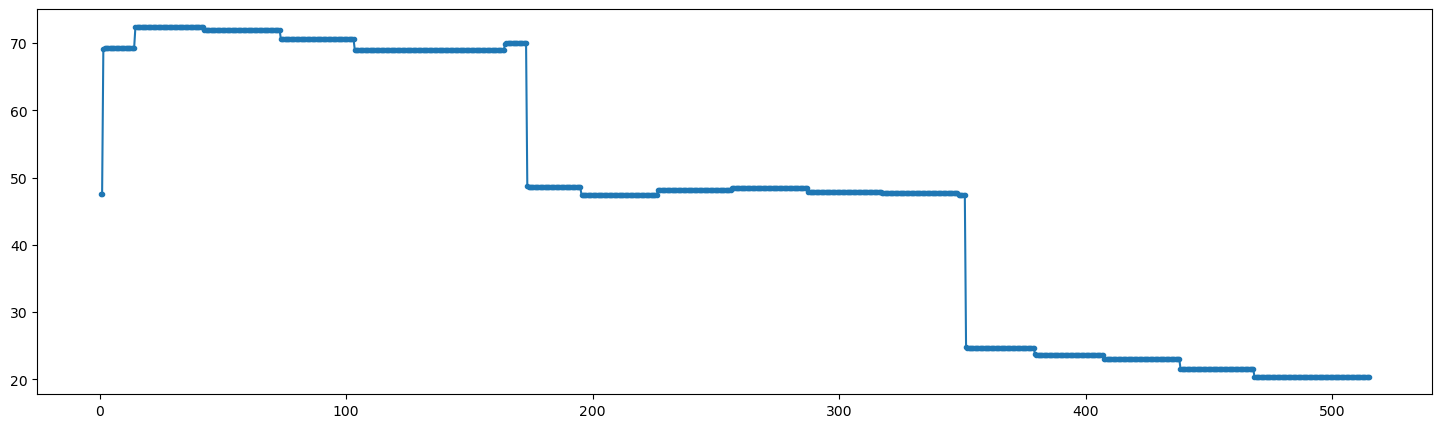

In [87]:
# plot head
f = 101
fig = plt.figure(num=f, figsize=(18, 5))
plt.plot(times_h, head[:, wel_lay, 0, wel_cellnum], marker=".")
f = f + 1

In [88]:
# Create list of components to plot based on intersection with transported components
components_to_plot = [c for c in component_name_l if c in ['Ca', 'Cl', 'K', 'N', 'Na']]
components_to_plot

['Ca', 'Cl', 'K', 'N', 'Na']

In [89]:
component_name_l

['H', 'O', 'Charge', 'Ca', 'Cl', 'K', 'N', 'Na']

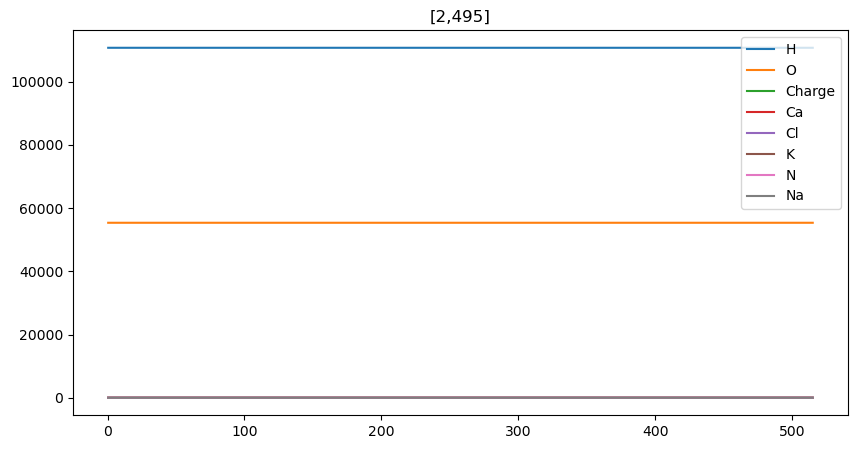

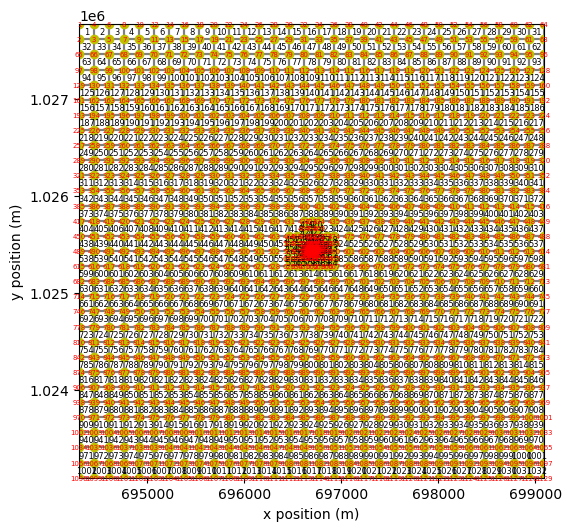

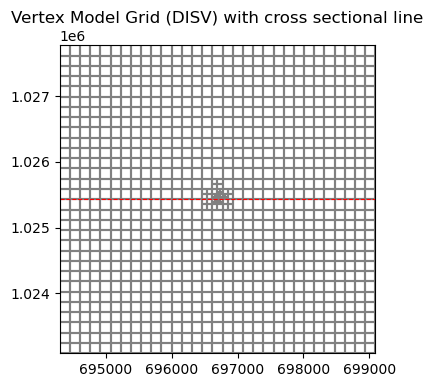

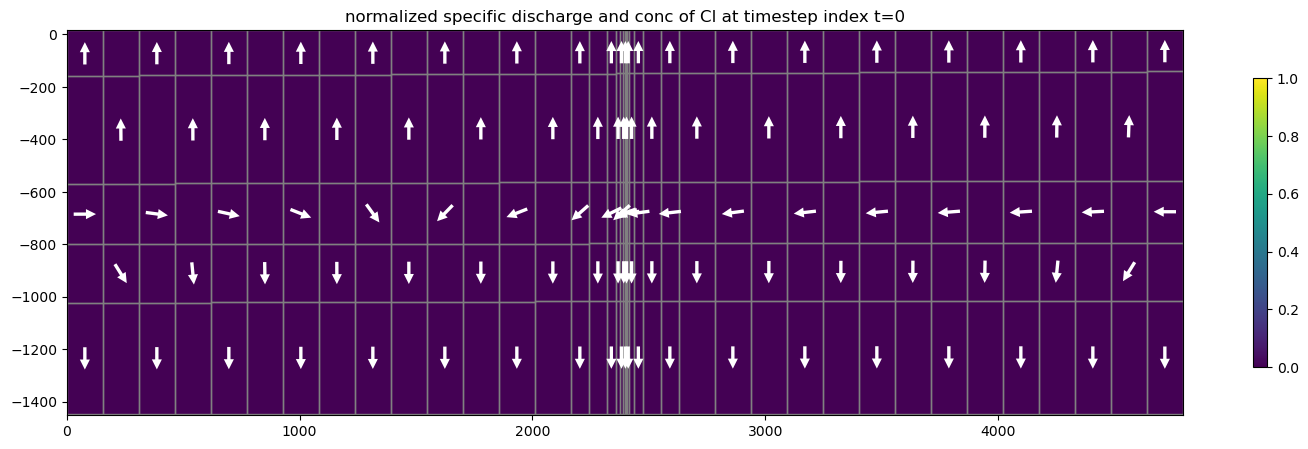

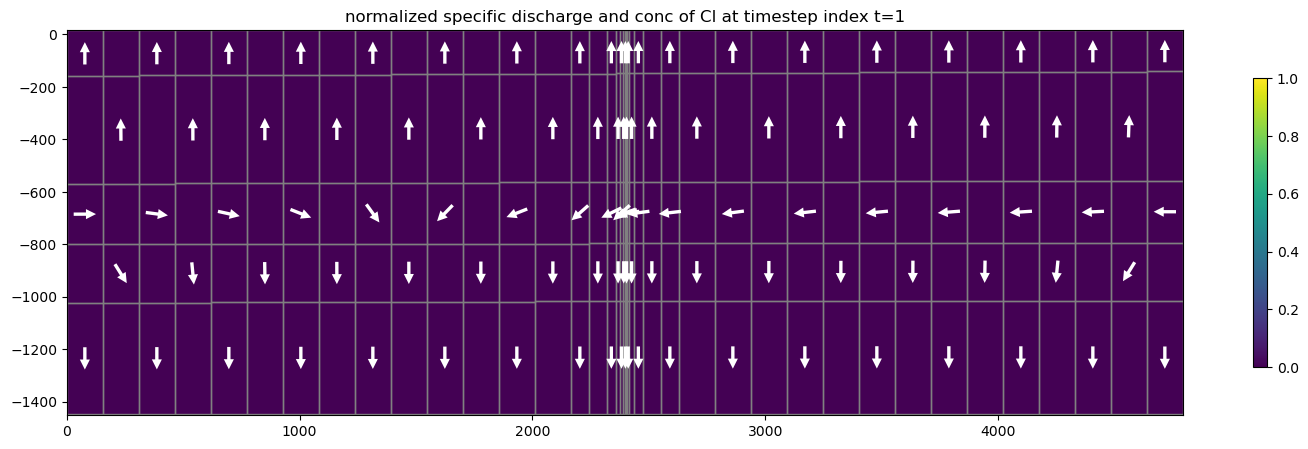

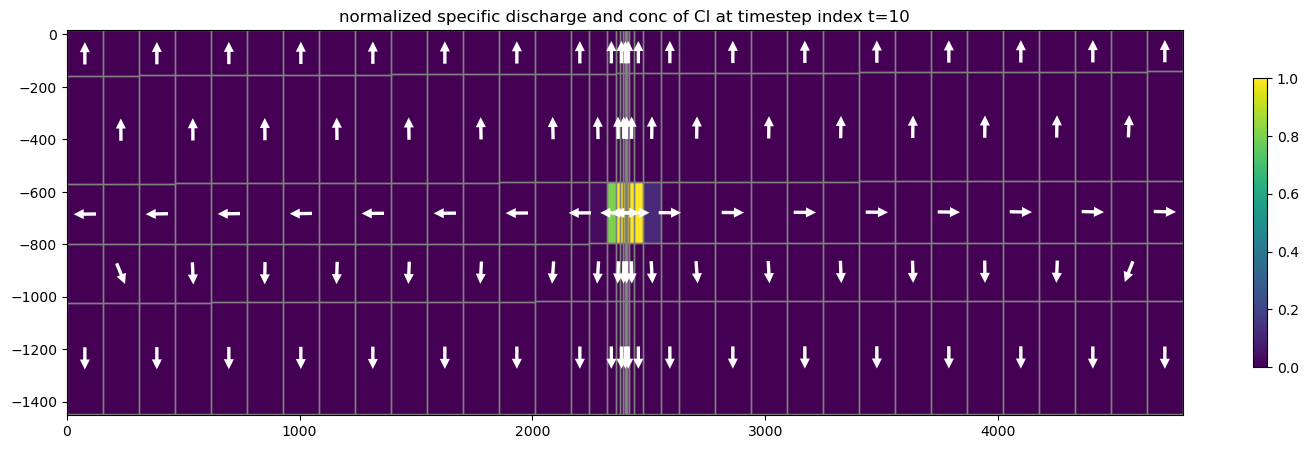

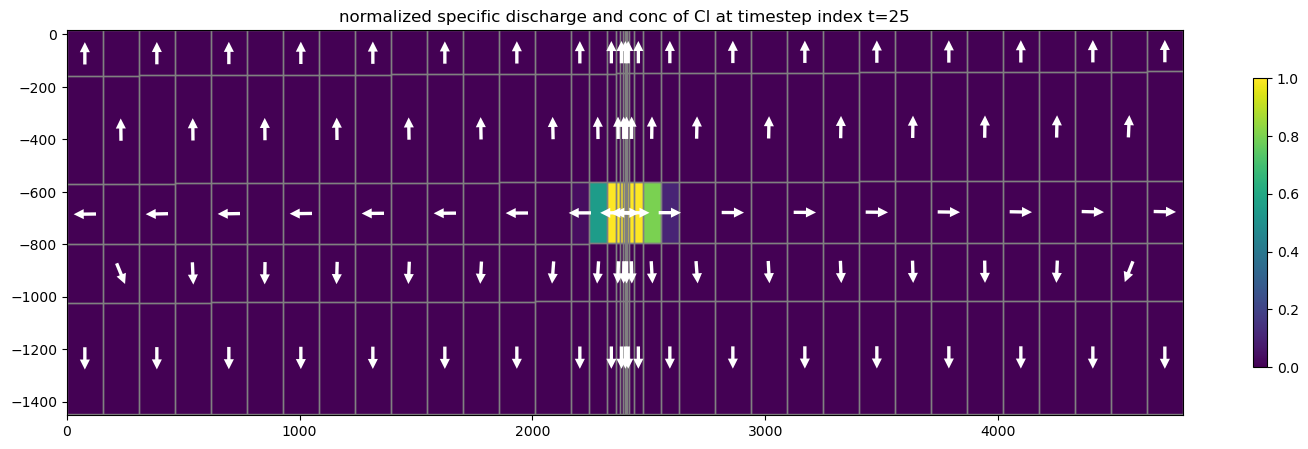

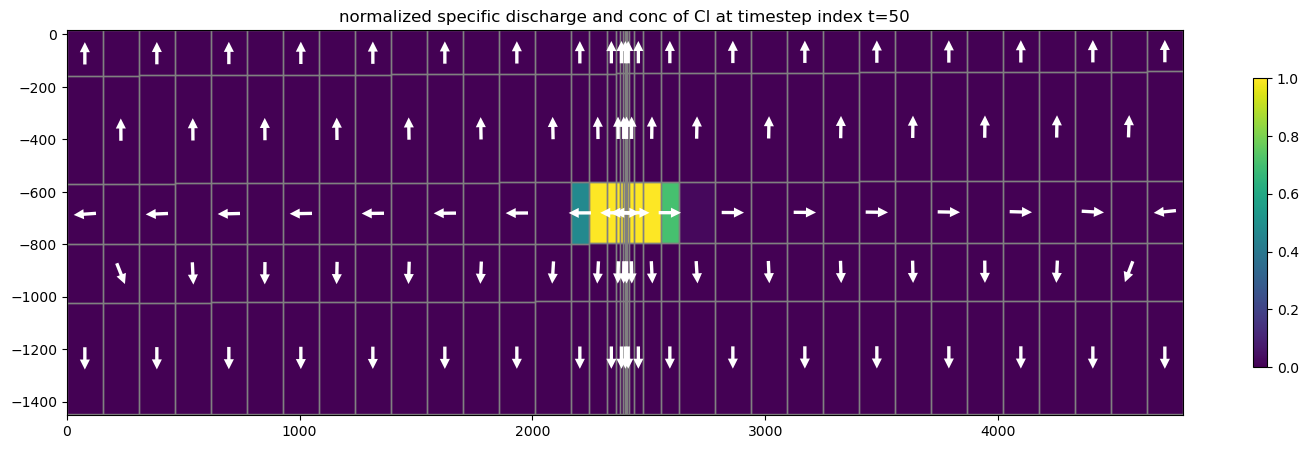

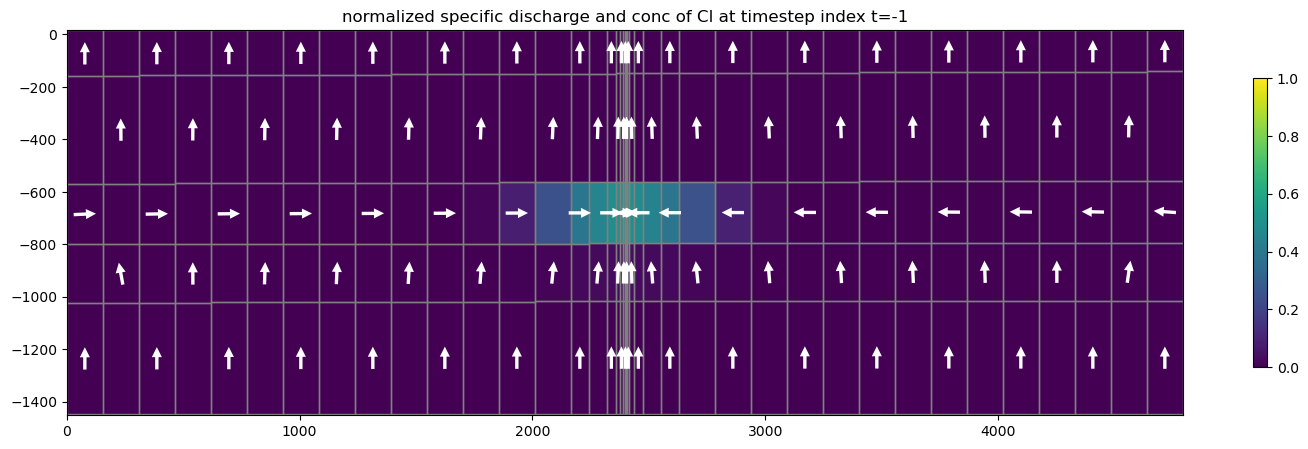

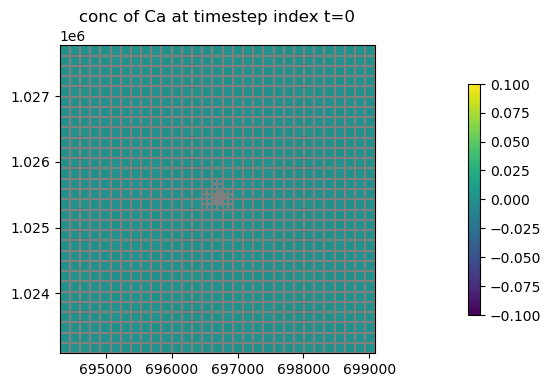

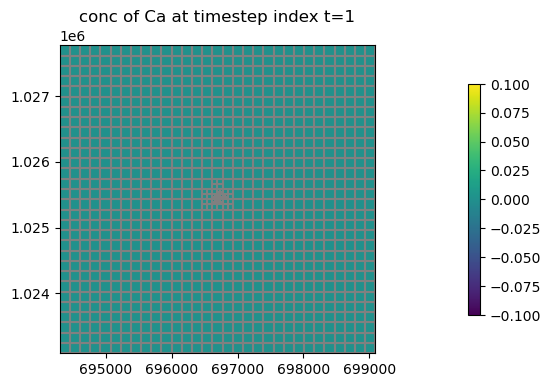

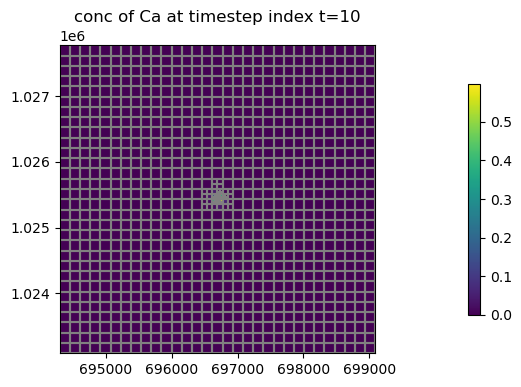

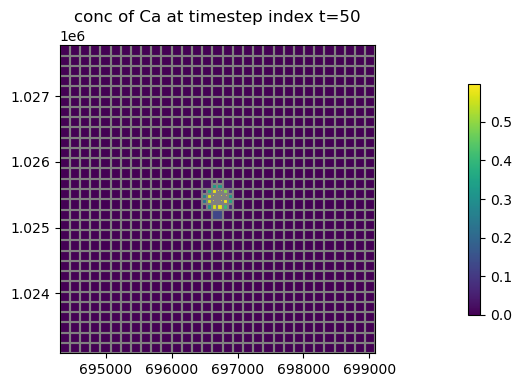

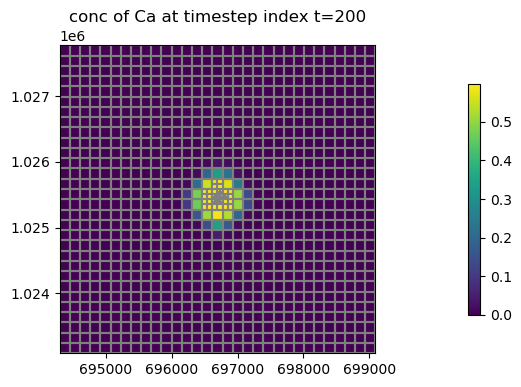

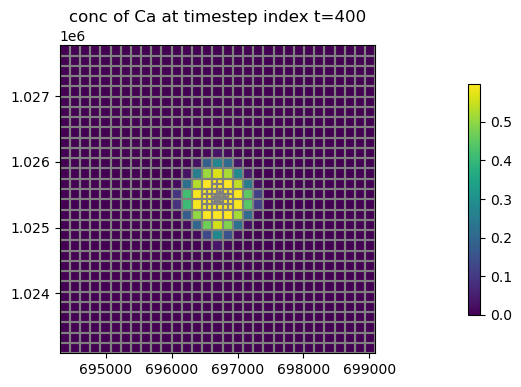

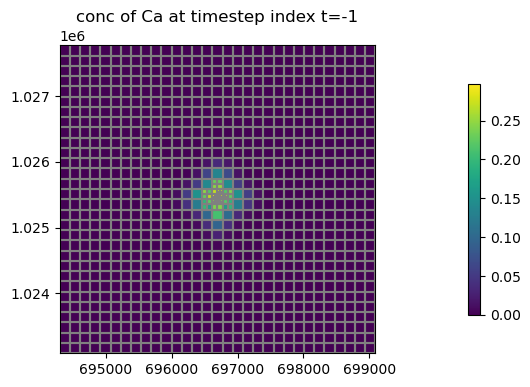

: 

In [ ]:


k = wel_lay  # layer index
cnum = wel_cellnum  # cell number
for c in range(len(component_name_l)):
    fig = plt.figure(num=101, figsize=(10, 5))
    plt.plot(times_c[c], conc[c][:, k, 0, cnum], label=component_name_l[c])
    plt.title("[" + str(k) + "," + str(cnum) + "]")
    plt.legend()


# # temp and tds gwt output
# temp_tds_l = ["temp", "tds"]
# temp_tds_output = utils.get_concentrations(sim, temp_tds_l)
# times_temptds = utils.get_times_c(sim, temp_tds_l)
# for c in range(len(temp_tds_l)):
#     fig = plt.figure(figsize=(18, 5))
#     plt.plot(times_temptds[c], temp_tds_output[c][:, k, 0, cnum])
#     plt.title(temp_tds_l[c] + " [" + str(k) + "," + str(cnum) + "]")
# # tds and temp plan view figures
# s = 1  # temp_tds_l index
# t_l = [0, 5, 10, 30, 50, -1]  # list of timestep index (NOT actual time/days)
# for t in t_l:
#     fig = plt.figure(figsize=(24, 4))
#     ax = fig.add_subplot(1, 1, 1, aspect="auto")
#     ax.set_title("conc of " + temp_tds_l[s] + " at timestep index t=" + str(t))
#     mapview = flopy.plot.PlotMapView(gwf, layer=3)  # ,extent=(0,0.08,0,1.))
#     patch_collection = mapview.plot_array(
#         temp_tds_output[s][t, :, :, :]
#     )  # ,vmin=26.600, vmax=26.61)
#     linecollection = mapview.plot_grid()
#     cb = plt.colorbar(patch_collection, shrink=0.75)


# xsection
gwf_name = "flow"
gwf = sim.get_model(gwf_name)

# plot map view of grid showing order of grid cell ids and vertices from:
# https://modflow6-examples.readthedocs.io/en/latest/_notebooks/ex-gwf-u1disv.html
fig = plt.figure(figsize=(6,6))
fig.tight_layout()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
pmv.plot_grid()
pmv.plot_bc(name="ghb", alpha=0.75)
pmv.plot_bc(name="wel", alpha=0.75)
ax.set_xlabel("x position (m)")
ax.set_ylabel("y position (m)")
for i, (x, y) in enumerate(
    zip(gwf.modelgrid.xcellcenters, gwf.modelgrid.ycellcenters)
):
    ax.text(
        x,
        y,
        f"{i + 1}",
        fontsize=6,
        horizontalalignment="center",
        verticalalignment="center",
    )
v = gwf.disv.vertices.array
ax.plot(v["xv"], v["yv"], "yo")
for i in range(v.shape[0]):
    x, y = v["xv"][i], v["yv"][i]
    ax.text(
        x,
        y,
        f"{i + 1}",
        fontsize=5,
        color="red",
        horizontalalignment="center",
        verticalalignment="center",
    )
plt.show()


# to plot a cross section with disv, you have to make a line to plot along

line = np.array([(694298, 1025429), (6999092, 1025429)])
# creates a plot showing where the line is on the grid to make the cross section plot
fig = plt.figure(figsize=(24, 4))
ax = fig.add_subplot(1, 1, 1, aspect="auto")
ax.set_title("Vertex Model Grid (DISV) with cross sectional line")
# ax.set_xlim(0,0.08)
# ax.set_ylim(0,1.)
# use PlotMapView to plot a DISV (vertex) model
mapview = flopy.plot.PlotMapView(gwf, layer=1)  # ,extent=(0,0.08,0,1.))
# mapview.plot_bc("WEL-1")
# mapview.plot_bc("CHD-1")
linecollection = mapview.plot_grid()
# plot the line over the model grid
lc = plt.plot(line.T[0], line.T[1], "r--", lw=0.8)
plt.show()

# creates a cross section along the line specified above for each timestep in t_l
s = 4  # solute index for Cl
t_l = [0, 1, 10, 25, 50, -1]  # list of timestep index (NOT actual time/days)
normalize = True
if normalize == True:
    scale = 50
else:
    scale = 100
for t in t_l:
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
        spdis[t], gwf, head=head[t]
    )
    fig = plt.figure(figsize=(18, 5))
    ax = fig.add_subplot(1, 1, 1)
    if normalize == True:
        ax.set_title(
            "normalized specific discharge and conc of "
            + component_name_l[s]
            + " at timestep index t="
            + str(t)
        )
    else:
        ax.set_title(
            "specific discharge and conc of "
            + component_name_l[s]
            + " at timestep index t="
            + str(t)
        )
    xsect = flopy.plot.PlotCrossSection(model=gwf, line={"line": line})
    patch_collection = xsect.plot_array(conc[s][t, :, :, :], vmin=0.0, vmax=1.0)
    line_collection = xsect.plot_grid()
    quiver = xsect.plot_vector(
        qx,
        qy,
        qz,
        head=head,
        hstep=2,
        normalize=normalize,
        color="white",
        scale=scale,  # changes arrow length
        width=0.003,
        headwidth=3,
        headlength=3,
        headaxislength=3,
        zorder=10,
    )
    cb = plt.colorbar(patch_collection, shrink=0.75)
    ## TODO: add a legend for the quiver to relate to spdis magnitude when noralized = False..?

s = 3  # solute index for Ca
t_l = [0, 1, 10, 50, 200, 400, -1]  # list of timestep index (NOT actual time/days)
for t in t_l:
    fig = plt.figure(figsize=(24, 4))
    ax = fig.add_subplot(1, 1, 1, aspect="auto")
    ax.set_title("conc of " + component_name_l[s] + " at timestep index t=" + str(t))
    mapview = flopy.plot.PlotMapView(gwf, layer=2)  # ,extent=(0,0.08,0,1.))
    patch_collection = mapview.plot_array(conc[s][t, :, :, :])  # ,vmin=0., vmax=0.2)
    linecollection = mapview.plot_grid()
    cb = plt.colorbar(patch_collection, shrink=0.75)

# Reactive Transport Simulation
Using MF6RTM

In [ ]:
# Run the model using this wrapper function for `mf6rtm.solve(model.wd)`
reaction_model.run()

Running mf6rtm
Processing initial chemistry configuration
Starting Solution at 2025-11-14 16:24:53
Transport       | Stress period:  1     | Time step:      1          | Completed in :  0 min   5.21e-05 sec
Reactions       | Stress period:  1     | Time step:      1          | Completed in :  0 min   5.66e-03 sec
Transport       | Stress period:  1     | Time step:      2          | Completed in :  0 min   4.08e-05 sec
Reactions       | Stress period:  1     | Time step:      2          | Completed in :  0 min   5.08e-03 sec
Transport       | Stress period:  2     | Time step:      1          | Completed in :  0 min   1.84e-04 sec
Reactions       | Stress period:  2     | Time step:      1          | Completed in :  0 min   5.49e-03 sec
Transport       | Stress period:  2     | Time step:      2          | Completed in :  0 min   2.00e-04 sec


Reactions       | Stress period:  2     | Time step:      2          | Completed in :  0 min   6.11e-03 sec
Transport       | Stress period:  2     | Time step:      3          | Completed in :  0 min   1.52e-04 sec


Reactions       | Stress period:  2     | Time step:      3          | Completed in :  0 min   5.79e-03 sec
Transport       | Stress period:  2     | Time step:      4          | Completed in :  0 min   1.35e-04 sec


Reactions       | Stress period:  2     | Time step:      4          | Completed in :  0 min   5.59e-03 sec
Transport       | Stress period:  2     | Time step:      5          | Completed in :  0 min   1.27e-04 sec


Reactions       | Stress period:  2     | Time step:      5          | Completed in :  0 min   5.60e-03 sec
Transport       | Stress period:  2     | Time step:      6          | Completed in :  0 min   1.22e-04 sec


Reactions       | Stress period:  2     | Time step:      6          | Completed in :  0 min   5.80e-03 sec
Transport       | Stress period:  2     | Time step:      7          | Completed in :  0 min   1.02e-04 sec
Reactions       | Stress period:  2     | Time step:      7          | Completed in :  0 min   5.82e-03 sec
Transport       | Stress period:  2     | Time step:      8          | Completed in :  0 min   8.88e-05 sec


Reactions       | Stress period:  2     | Time step:      8          | Completed in :  0 min   5.68e-03 sec
Transport       | Stress period:  2     | Time step:      9          | Completed in :  0 min   9.42e-05 sec


Reactions       | Stress period:  2     | Time step:      9          | Completed in :  0 min   6.47e-03 sec
Transport       | Stress period:  2     | Time step:      10         | Completed in :  0 min   1.06e-03 sec


Reactions       | Stress period:  2     | Time step:      10         | Completed in :  0 min   5.77e-03 sec
Transport       | Stress period:  2     | Time step:      11         | Completed in :  0 min   6.92e-05 sec


Reactions       | Stress period:  2     | Time step:      11         | Completed in :  0 min   5.64e-03 sec
Transport       | Stress period:  2     | Time step:      12         | Completed in :  0 min   7.08e-05 sec


Reactions       | Stress period:  2     | Time step:      12         | Completed in :  0 min   5.92e-03 sec
Transport       | Stress period:  2     | Time step:      13         | Completed in :  0 min   6.60e-05 sec


Reactions       | Stress period:  2     | Time step:      13         | Completed in :  0 min   5.83e-03 sec
Transport       | Stress period:  2     | Time step:      14         | Completed in :  0 min   6.85e-05 sec
Reactions       | Stress period:  2     | Time step:      14         | Completed in :  0 min   5.68e-03 sec


# END